# Quick start with Retentioneering

## Prerequisites

Run this cell to prepare the environment. This step is obligatory.

In [1]:
!pip install retentioneering

In [2]:
import retentioneering
import pandas as pd

The full text of [Quick start](https://doc.retentioneering.com/stable/doc/getting_started/quick_start.html) user guide is available on the retentioneering website.

## Loading data

In [3]:
from retentioneering import datasets

# load sample user behavior data:
stream = datasets.load_simple_shop()

In [4]:
stream.to_dataframe().head()

event_id  event_type  event_index       event  \
0  adcae8bd-6049-4407-b27e-3a9d9f8bf301  path_start            0  path_start   
1  adcae8bd-6049-4407-b27e-3a9d9f8bf301         raw            0     catalog   
2  60197370-7ff4-4e57-b1a5-ee9a4d1fffac         raw            1    product1   
3  38d8a78f-94ac-434f-9711-edbc0e7b7814         raw            2        cart   
4  669bfe5a-2ddf-4b7d-8bbc-023980752c8e         raw            3     catalog   

                   timestamp    user_id  
0 2019-11-01 17:59:13.273932  219483890  
1 2019-11-01 17:59:13.273932  219483890  
2 2019-11-01 17:59:28.459271  219483890  
3 2019-11-01 17:59:29.502214  219483890  
4 2019-11-01 17:59:32.557029  219483890

## Preparing the data

In [5]:
# eventstream preprocessing example
stream = stream.split_sessions(timeout=(30, 'm'))

stream\
    .filter_events(func=lambda _df: _df['session_id'].str.endswith('_1'))\
    .to_dataframe()\
    .head()

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/data_processors_lib/split_sessions.py:318: FutureWarning: The provided callable <function cumsum at 0x1165c11c0> is currently using SeriesGroupBy.cumsum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "cumsum" instead.
  df[session_col] = df.groupby(user_col)[self.IS_SESSION_START_COL].transform(np.cumsum)


event_id     event_type  event_index  \
0  adcae8bd-6049-4407-b27e-3a9d9f8bf301     path_start            0   
1  129292c8-af85-46c7-9c8f-bfa27be39ad6  session_start            0   
2  adcae8bd-6049-4407-b27e-3a9d9f8bf301            raw            0   
3  60197370-7ff4-4e57-b1a5-ee9a4d1fffac            raw            1   
4  38d8a78f-94ac-434f-9711-edbc0e7b7814            raw            2   

           event                  timestamp    user_id   session_id  
0     path_start 2019-11-01 17:59:13.273932  219483890  219483890_1  
1  session_start 2019-11-01 17:59:13.273932  219483890  219483890_1  
2        catalog 2019-11-01 17:59:13.273932  219483890  219483890_1  
3       product1 2019-11-01 17:59:28.459271  219483890  219483890_1  
4           cart 2019-11-01 17:59:29.502214  219483890  219483890_1

# Applying path analysis tools

## Transition graph

In [6]:
stream.transition_graph()

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/nodelist/nodelist.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.nodelist_df = pd.concat([self.nodelist_df, new_nodes])


## Step matrix

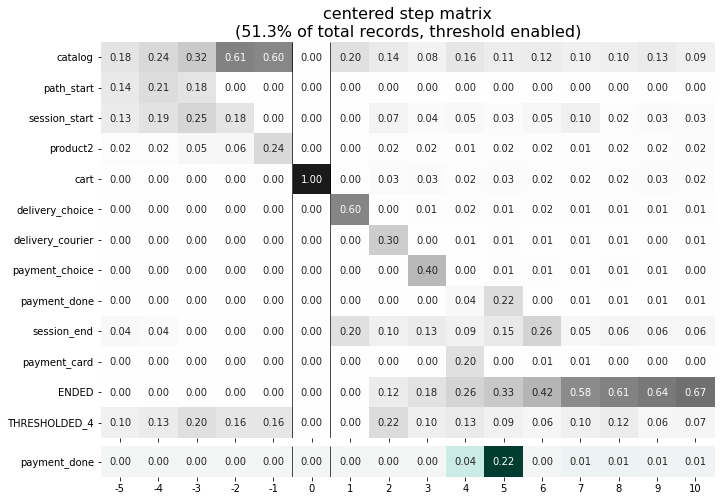

In [7]:
stream.step_matrix(
    max_steps=16,
    threshold=0.2,
    centered={
        'event': 'cart',
        'left_gap': 5,
        'occurrence': 1
    },
    targets=['payment_done']
)

## Transition matrix

In [8]:
def session_count_segment(df):
    df['session_count'] = df['session_id'].str.split('_').str[1]
    return df['session_count']

stream = stream.add_segment(session_count_segment, 'session_count')

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/nodelist/nodelist.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.nodelist_df = pd.concat([self.nodelist_df, new_nodes])
/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/tooling/transition_matrix/transition_matrix.py:137: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame = pd.DataFrame(columns=event_list, index=event_list).fillna(self.__fill_value)
/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/nod

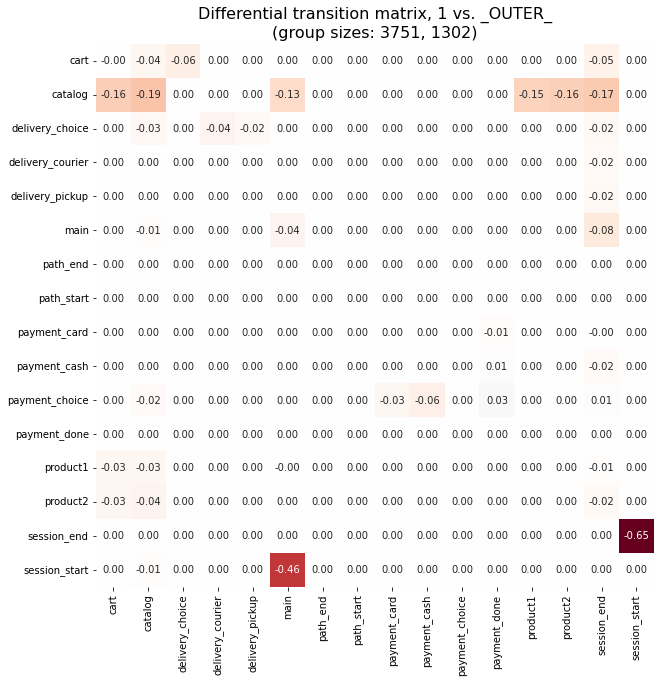

In [9]:
stream.transition_matrix(norm_type='node', groups=['session_count', '1', '_OUTER_'])

## Step Sankey diagram

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/tooling/step_sankey/step_sankey.py:265: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["time_to_next"].fillna(data["time_to_next"].min(), inplace=True)


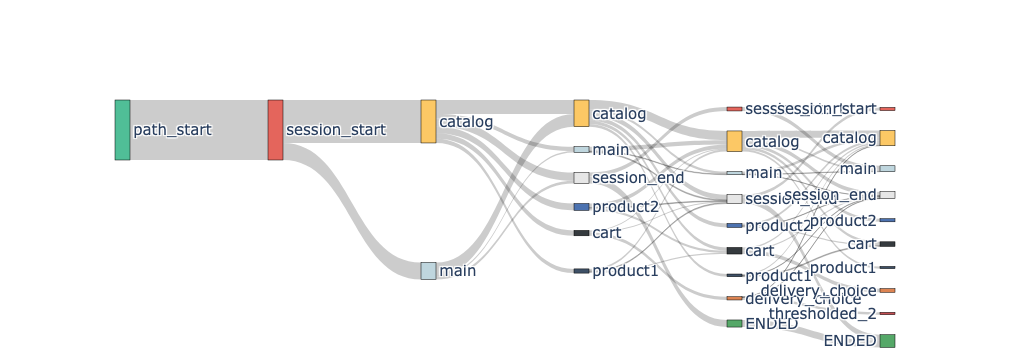

In [10]:
stream.step_sankey(max_steps=6, threshold=0.05)

## Cluster analysis

In [11]:
features = stream.extract_features(feature_type='count', ngram_range=(1, 1))
stream = stream.get_clusters(method='kmeans', n_clusters=8, X=features, segment_name='kmeans_clusters')

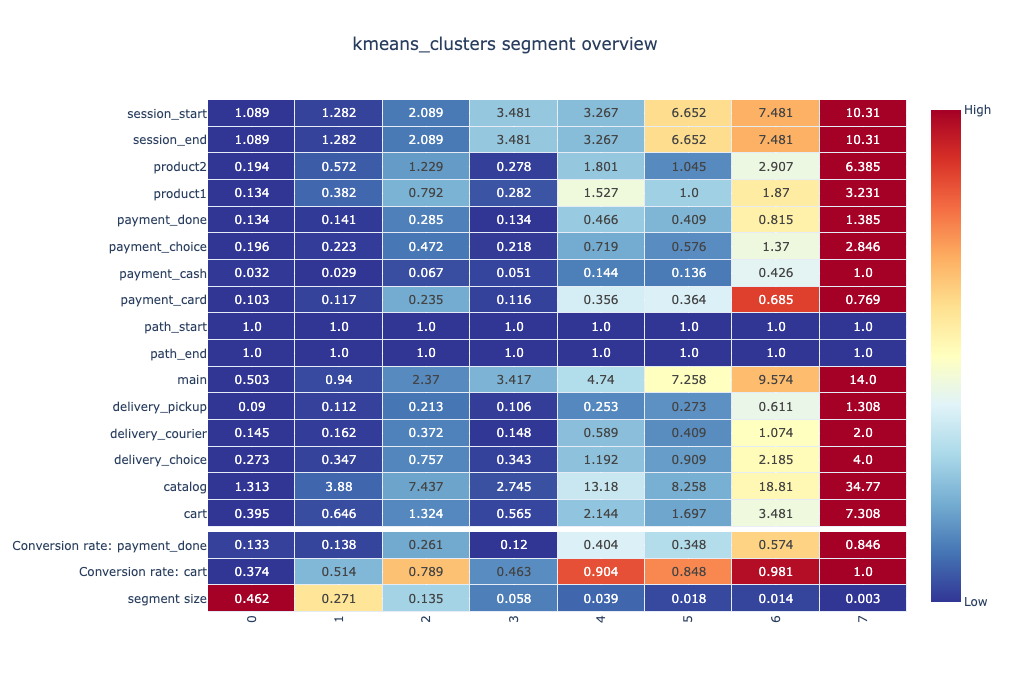

In [12]:
custom_metrics = [
    ('segment_size', 'mean', 'segment size'),
    ('has:cart', 'mean', 'Conversion rate: cart'),
    ('has:payment_done', 'mean', 'Conversion rate: payment_done'),
]

stream.clusters_overview('kmeans_clusters', features, aggfunc='mean', metrics=custom_metrics)

## Funnel analysis

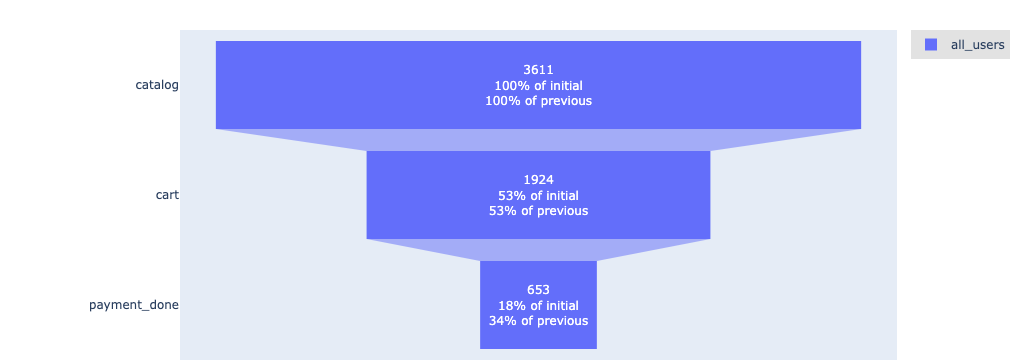

In [13]:
stream.funnel(stages=['catalog', 'cart', 'payment_done'])

## Cohort analysis

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/tooling/cohorts/cohorts.py:77: FutureWarning:

The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.



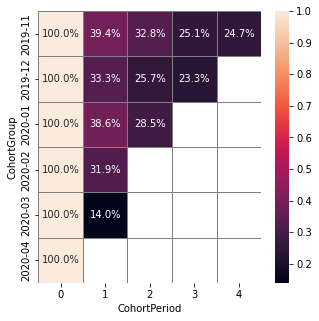

In [14]:
stream.cohorts(
    cohort_start_unit='M',
    cohort_period=(1, 'M'),
    average=False,
)

## Sequences

In [15]:
stream.sequences(
    ngram_range=(2, 3),
    threshold=['count', 1200],
    sample_size=3
)